In [13]:
# Using cv2 weighted overlay

In [14]:
from PIL import Image
import torch
import os
import numpy as np
import pickle
from utils.utils import *
from utils.file_utils import save_pkl, load_pkl
from models.resnet_custom import resnet50_baseline
from models.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import cv2 as cv

In [15]:
drop_out = False
n_classes = 2
split = 1
model_type = "clam_sb"
model_size = 'small'
exp_code = "exp_6" + "_s1"
results_dir = "image_sets/results"

data_dir = "image_sets/original/"
image_ext = ".tif"
patch_dir = "image_sets/patches/"
feat_dir = "image_sets/features/"
actual_feat_dir = "image_sets/patches/fungal_vs_nonfungal_resnet_features/pt_files/"

save_path = os.path.join(results_dir, exp_code, "heatmaps")
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    
heatmap_dict = "split_"+str(split)+"_heatmap_dict.pkl"

In [16]:
patch_size = (256, 256)
alpha = 1
beta = 0.5
gamma = 0.0
cmap='coolwarm'

In [17]:
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, heatmap_dict))

In [18]:
image_file = heatmap_dict[0]

image_name = image_file['filename']
attention_scores = image_file['attention_scores']
coords_list = image_file['coords_list']

In [19]:
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

img_path = os.path.join(data_dir, image_name+image_ext)
# orig_img = np.array(Image.open(img_path))
# orig_img = orig_img[0:1024, 0:1536] # No left-overs

orig_img = cv.imread(img_path)
orig_img = orig_img[0:1024, 0:1536] # No left-overs

In [20]:
scores = attention_scores[0].copy()
scores = [float(x) for x in scores]
percentiles = []
for score in scores:
    percentile = percentileofscore(scores, score)
    percentiles.append(percentile/100)
print(scores)
print()
print(percentiles)

[0.021716471761465073, 0.01663416251540184, 0.029489200562238693, 0.05264200270175934, 0.04641733318567276, 0.016626490280032158, 0.04939887672662735, 0.04594659432768822, 0.02802308462560177, 0.04418737813830376, 0.025477584451436996, 0.11814568191766739, 0.04128209128975868, 0.023498335853219032, 0.0523499958217144, 0.040871087461709976, 0.04925018548965454, 0.07641477882862091, 0.054671064019203186, 0.03878528252243996, 0.04447605088353157, 0.04186148941516876, 0.0246889665722847, 0.017145784571766853]

[0.16666666666666669, 0.08333333333333334, 0.375, 0.875, 0.7083333333333333, 0.04166666666666667, 0.7916666666666667, 0.6666666666666667, 0.33333333333333337, 0.5833333333333334, 0.2916666666666667, 1.0, 0.5, 0.20833333333333331, 0.8333333333333333, 0.45833333333333337, 0.75, 0.9583333333333333, 0.9166666666666667, 0.41666666666666663, 0.625, 0.5416666666666666, 0.25, 0.125]


In [21]:
# heatmap_mask = Image.new("RGB", (1536, 1024), (0, 0, 0))
# heatmap_mask = cv.cvtColor(np.array(heatmap_mask), cv.COLOR_RGB2BGR)

In [22]:
heatmap_mask = np.zeros([1024, 1536, 3])

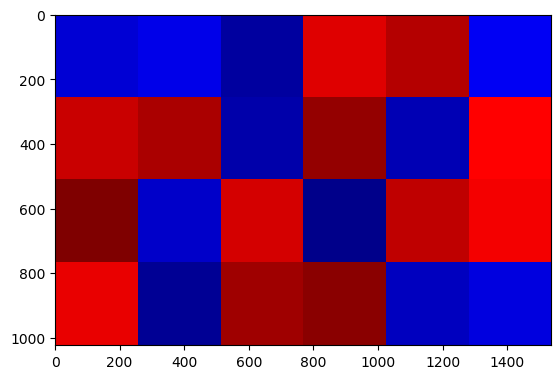

In [23]:
threshold = 0.5

for index, score in enumerate(percentiles):
    x = 256 * coords_list[0][0][index].item() # Top left corner
    y = 256 * coords_list[0][1][index].item() # Top left corner
#     print("Score, x, y:", score, x, y)
#     print(x, y, x+patch_size[0], y+patch_size[1])
    
    if (score >= threshold):
        heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], 0] = score
    else:
        heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], 2] = 1-score

# print(heatmap_mask)
plt.imshow(heatmap_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


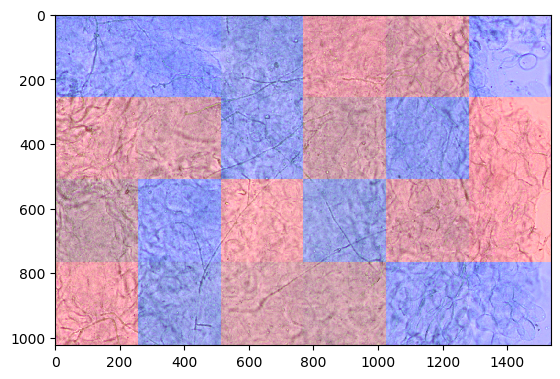

In [24]:
img_heatmap_filename = os.path.join(save_path, image_name+"_heatmap"+".jpg")

# print(orig_img.shape)
# print(heatmap_mask.shape)

orig_img = orig_img.astype(np.float32)
orig_img /= 255

# print(orig_img.max())
# print(heatmap_mask.max())

alpha = 1
beta = 0.4
gamma = 0.0

# heatmap_mask = cv.cvtColor(np.array(heatmap_mask).astype(np.uint8), cv.COLOR_RGB2BGR)

img_heatmap = cv.addWeighted(orig_img, alpha, heatmap_mask, beta, gamma, dtype=cv.CV_64F)
if not cv.imwrite(img_heatmap_filename, img_heatmap):
     raise Exception("Could not save the heatmap", img_heatmap_filename)
plt.imshow(img_heatmap)